In [2]:
#Importing the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

#from tqdm import *

Using TensorFlow backend.


In [3]:
#Reading the traning file
train = pd.read_csv('./data/train_2.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
#the Page colum is not neccesary for training the model
train=train.drop('Page',axis=1)
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [22]:
# how many days will you get to predict your model
INPUT_DAYS = 50
# number of days in future model will try to predict
OUTPUT_DAYS = 15
# number of days used to train
WINDOW_RANGE = 365
# number of shift for val data
SHIFT_VAL = 90

def createLSTMModel():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 512, input_shape = (None, 1)))
    regressor.add(Dropout(0.5))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    return regressor

def createLSTMModelOld():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 24, activation = 'relu', input_shape = (None, 1)))
    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    return regressor

def createRegressionModel():
    model = Sequential()
    model.add(Dense(4, input_dim=3, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

def calculateError(y_test, y_pred):
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    return rms

In [23]:
# get Train, Validation and Test data

rows_values = [32282, 60282, 129719, 126098]
#rows_values = range(0,train.shape[0])

X_train = np.empty((0,INPUT_DAYS))
Y_train = np.empty((0,OUTPUT_DAYS-1))
X_val = np.empty((0,INPUT_DAYS))
Y_val = np.empty((0,OUTPUT_DAYS-1))
for row in rows_values:
    train_row = train.iloc[row,:].values

    X_train1 = np.reshape(train_row[0:WINDOW_RANGE],(-1,1))
    X_val1 = np.reshape(train_row[SHIFT_VAL:WINDOW_RANGE+SHIFT_VAL],(-1,1))
    for i in range(1,INPUT_DAYS):
        x_train1 = train_row[i:WINDOW_RANGE+i]
        X_train1 = np.append(X_train1, np.reshape(x_train1,(-1,1)), axis=1)
        x_val1 = train_row[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
        X_val1 = np.append(X_val1, np.reshape(x_val1,(-1,1)), axis=1)

    Y_train1 = np.reshape(train_row[INPUT_DAYS+1:WINDOW_RANGE+INPUT_DAYS+1],(-1,1))
    Y_val1 = np.reshape(train_row[INPUT_DAYS+1+SHIFT_VAL:WINDOW_RANGE+INPUT_DAYS+1+SHIFT_VAL],(-1,1))
    for i in range(INPUT_DAYS+2, INPUT_DAYS+OUTPUT_DAYS):
        y_train1 = train_row[i:WINDOW_RANGE+i]
        Y_train1 = np.append(Y_train1, np.reshape(y_train1,(-1,1)), axis=1)
        y_val1 = train_row[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
        Y_val1 = np.append(Y_val1, np.reshape(y_val1,(-1,1)), axis=1)

    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc_X = MinMaxScaler(feature_range=(0, 1))
    sc_Y = MinMaxScaler(feature_range=(0, 1))
    X_train1 = sc_X.fit_transform(X_train1)
    Y_train1 = sc_Y.fit_transform(Y_train1)
    X_val1 = sc_X.transform(X_val1)
    Y_val1 = sc_Y.transform(Y_val1)
    
    X_train = np.append(X_train, X_train1, axis=0)
    Y_train = np.append(Y_train, Y_train1, axis=0)
    X_val = np.append(X_val, X_val1, axis=0)
    Y_val = np.append(Y_val, Y_val1, axis=0)
    


In [24]:
#Reshaping Array for Regression
#X_train = np.reshape(X_train, (WINDOW_RANGE,INPUT_DAYS))
#X_val = np.reshape(X_train, (WINDOW_RANGE,INPUT_DAYS))
#Reshaping Array for LSTM
X_train = np.reshape(X_train, (WINDOW_RANGE*len(rows_values),INPUT_DAYS,1))
X_val = np.reshape(X_val, (WINDOW_RANGE*len(rows_values),INPUT_DAYS,1))

# Initialising the RNN
regressors = []
for i in range(0,OUTPUT_DAYS-1):
    regressor = createLSTMModel()

    # Fitting the RNN to the Training set
    regressor.fit(X_train, Y_train[:,i], 
                  batch_size = 128, 
                  epochs = 5, 
                  verbose = 1, 
                  validation_data=(X_val, Y_val[:,i]))
    regressors.append(regressor)

Train on 1460 samples, validate on 1460 samples
Epoch 1/5
1460/1460 [==============================] - 21s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2/5
1460/1460 [==============================] - 23s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 3/5
1460/1460 [==============================] - 26s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 4/5
1460/1460 [==============================] - 22s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 5/5
1460/1460 [==============================] - 22s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Train on 1460 samples, validate on 1460 samples
Epoch 1/5
1460/1460 [==============================] - 23s 16ms/step - loss: 0.

Epoch 3/5
1460/1460 [==============================] - 21s 15ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 4/5
1460/1460 [==============================] - 18s 13ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 5/5
1460/1460 [==============================] - 19s 13ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Train on 1460 samples, validate on 1460 samples
Epoch 1/5
1460/1460 [==============================] - 22s 15ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2/5
1460/1460 [==============================] - 16s 11ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 3/5
1460/1460 [==============================] - 26s 18ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.

79480


'Root Mean Square - Pred 1: 111.87535032053019'

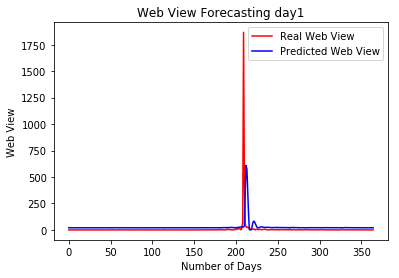

'Root Mean Square - Pred 2: 107.46699149047377'

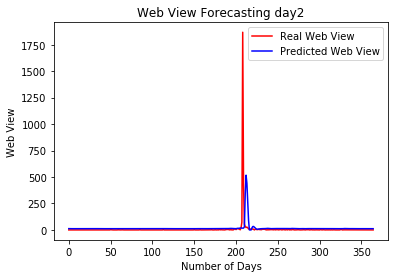

'Root Mean Square - Pred 3: 105.89326896647941'

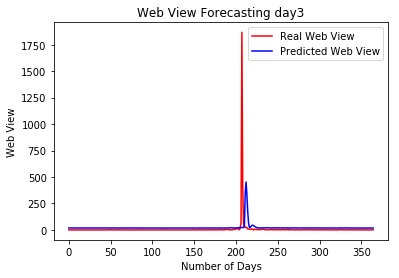

'Root Mean Square - Pred 4: 111.78692829801031'

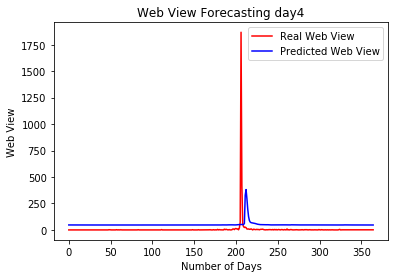

'Root Mean Square - Pred 5: 103.54245169190168'

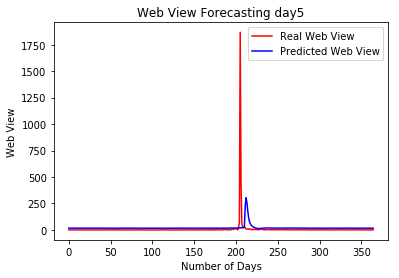

'Root Mean Square - Pred 6: 110.22298891717071'

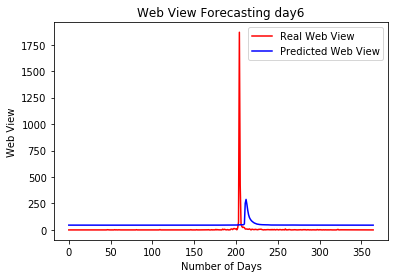

'Root Mean Square - Pred 7: 106.97271192822681'

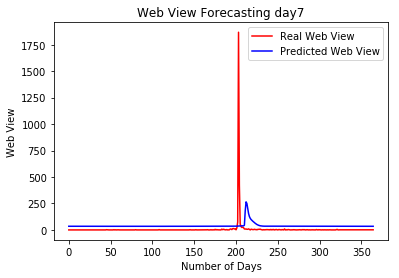

'Root Mean Square - Pred 8: 107.66933476841936'

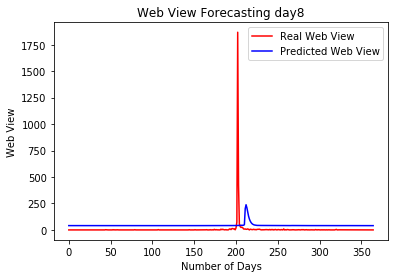

'Root Mean Square - Pred 9: 105.59539102624184'

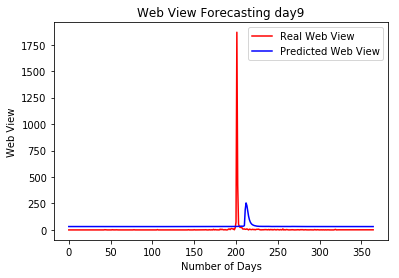

'Root Mean Square - Pred 10: 109.24857784264708'

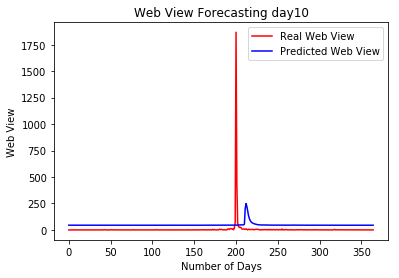

'Root Mean Square - Pred 11: 104.14628685283047'

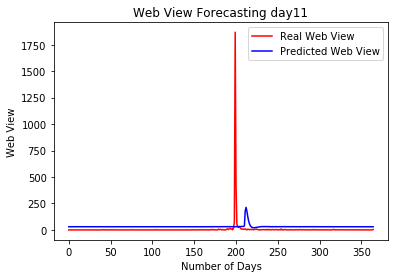

'Root Mean Square - Pred 12: 110.0110201839249'

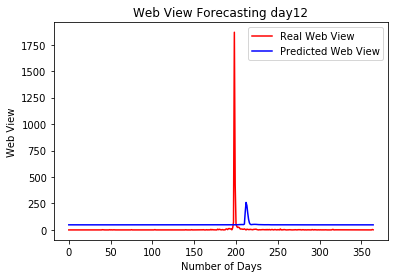

'Root Mean Square - Pred 13: 104.43880298450848'

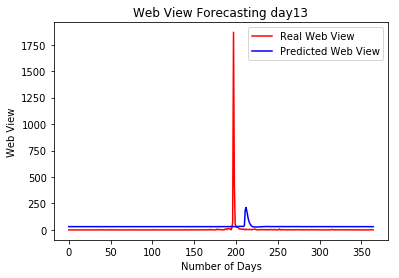

'Root Mean Square - Pred 14: 111.12749998800791'

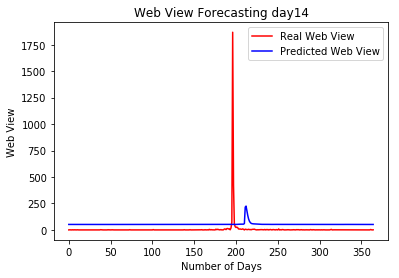

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython.display import display
import random

X_value = random.randint(0,train.shape[0])
print(X_value)

# Getting the predicted Web View
test_row = train.iloc[X_value,:].values

X_test = np.reshape(test_row[0:WINDOW_RANGE],(-1,1))
for i in range(1,INPUT_DAYS):
    x_test = test_row[i:WINDOW_RANGE+i]
    X_test = np.append(X_test, np.reshape(x_test,(-1,1)), axis=1)
    
y_test = np.reshape(test_row[INPUT_DAYS+1:WINDOW_RANGE+INPUT_DAYS+1],(-1,1))
for i in range(INPUT_DAYS+2, INPUT_DAYS+OUTPUT_DAYS):
    y = test_row[i:WINDOW_RANGE+i]
    y_test = np.append(y_test, np.reshape(y,(-1,1)), axis=1)

inputs = X_test
inputs = sc_X.transform(inputs)

# reshape for Regression
#inputs = np.reshape(inputs, (WINDOW_RANGE, INPUT_DAYS))
# reshape for LSTM
inputs = np.reshape(inputs, (WINDOW_RANGE, INPUT_DAYS,1))

Y_pred = np.empty((WINDOW_RANGE,0))
for i in range(0,OUTPUT_DAYS-1):
    regressor = regressors[i]
    y_pred = regressor.predict(inputs)
    #y_pred = sc_Y.inverse_transform(y_pred)
    #y_pred[y_pred < 0] = 0
    Y_pred = np.append(Y_pred, np.reshape(y_pred, (WINDOW_RANGE,1)), axis=1)

Y_pred = sc_Y.inverse_transform(Y_pred)
Y_pred[Y_pred < 0] = 0

for i in range(0,OUTPUT_DAYS-1):
    error = calculateError(y_test[:,i], Y_pred[:,i])
    
    display("Root Mean Square - Pred " + str(i+1) + ": " + str(error))

    #Visualising Result
    plt.figure
    plt.plot(y_test[:,i], color = 'red', label = 'Real Web View')
    plt.plot(Y_pred[:,i], color = 'blue', label = 'Predicted Web View')
    #plt.plot(X_test, color = 'green', label = 'Previous values')
    plt.title('Web View Forecasting day' + str(i+1))
    plt.xlabel('Number of Days')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()

In [ ]:
# calculate aggregated error from all data
all_errors = []
for i in range(0,train.shape[0]):

    # Getting the predicted Web View
    test_row = train.iloc[i,:].values

    X_test = np.reshape(test_row[(SHIFT_VAL*2):WINDOW_RANGE+(SHIFT_VAL*2)],(-1,1))
    for i in range(1,INPUT_DAYS):
        x_test = test_row[i+(SHIFT_VAL*2):WINDOW_RANGE+i+(SHIFT_VAL*2)]
        X_test = np.append(X_test, np.reshape(x_test,(-1,1)), axis=1)

    y_test = np.reshape(test_row[INPUT_DAYS+1+(SHIFT_VAL*2):WINDOW_RANGE+INPUT_DAYS+1+(SHIFT_VAL*2)],(-1,1))
    for i in range(INPUT_DAYS+2, INPUT_DAYS+OUTPUT_DAYS):
        y = test_row[i+(SHIFT_VAL*2):WINDOW_RANGE+i+(SHIFT_VAL*2)]
        y_test = np.append(y_test, np.reshape(y,(-1,1)), axis=1)

    inputs = X_test
    inputs = sc_X.transform(inputs)

    # reshape for Regression
    #inputs = np.reshape(inputs, (WINDOW_RANGE, INPUT_DAYS))
    # reshape for LSTM
    inputs = np.reshape(inputs, (WINDOW_RANGE*train.shape[0], INPUT_DAYS,1))

    Y_pred = np.empty((WINDOW_RANGE,0))
    for i in range(0,OUTPUT_DAYS-1):
        regressor = regressors[i]
        y_pred = regressor.predict(inputs)
        #y_pred = sc_Y.inverse_transform(y_pred)
        #y_pred[y_pred < 0] = 0
        Y_pred = np.append(Y_pred, np.reshape(y_pred, (WINDOW_RANGE,1)), axis=1)

    Y_pred = sc_Y.inverse_transform(Y_pred)
    Y_pred[Y_pred < 0] = 0

    for j in range(0,OUTPUT_DAYS-1):
        error = calculateError(y_test[:,j], Y_pred[:,j])
        all_errors.append(error)